In [37]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve
from scipy.interpolate import RectBivariateSpline
from pde_solvers.BurgerSolver import get_burger_solver
from EquationModel import InducedRKHS

In [38]:
from Kernels import get_gaussianRBF

In [39]:
@jax.vmap
@jax.jit
def f(x):
    return jnp.where(x<=0.5,x**2,0.25 - (x-0.5))

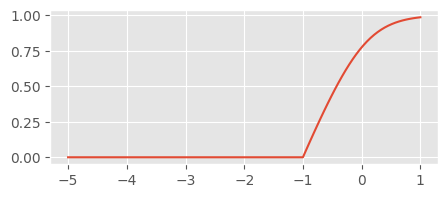

In [40]:
grid = jnp.linspace(-5,1,100)


def h(x,x0,beta = 3,side = -1):
    return (
        1-(
            jnp.log(1+jnp.exp(beta-beta*jnp.maximum(-1*side*(x0-x),0)))/
            jnp.log(1+jnp.exp(beta))
        )
    )
plt.figure(figsize=(5,2))
plt.plot(grid,h(grid,-1,3,1))
plt.show()

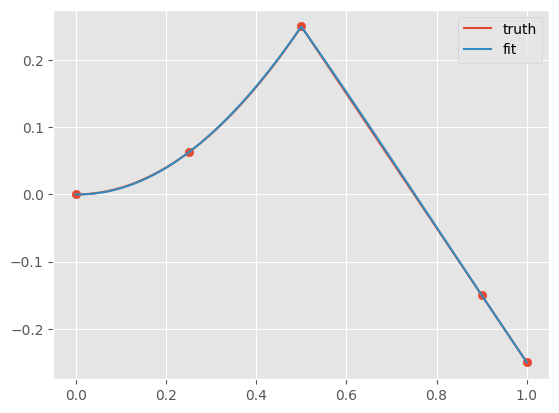

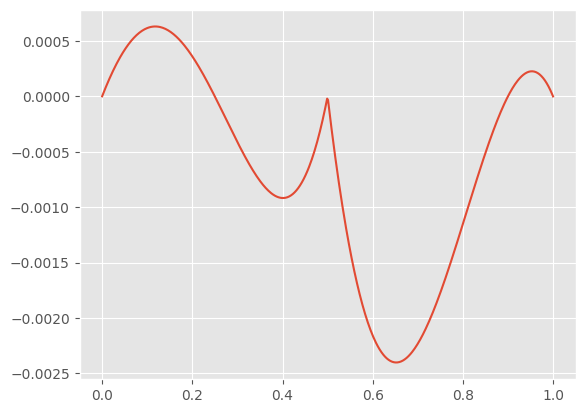

In [55]:
grid = jnp.linspace(0,1,500)

obs = jax.random.uniform(jax.random.PRNGKey(30),(5,),minval = 0,maxval = 1.)

obs = jnp.array([0.,0.25,0.5,0.9,1.])
y = f(obs)


rbf = get_gaussianRBF(2.)

@vectorize_kfunc
def k(x,y):
    return (
        rbf(x,y)*h(x,0.5,3)*h(y,0.5,3) + 
        rbf(x,y)*h(x,0.5,3,side = 1)*h(y,0.5,3,side = 1) +
        x*y+ 1 +
        0.5*rbf(x,y)
    )


K = k(obs,obs)

nugget = 1e-8
preds = k(grid,obs)@jnp.linalg.inv(K+nugget*diagpart(K))@y

Kobs = k(obs,obs)
posterior_var = k(grid,grid) - k(grid,obs)@jnp.linalg.inv(Kobs+nugget*diagpart(Kobs))@k(obs,grid)
sd = jnp.sqrt(jnp.diag(posterior_var))
plt.plot(grid,f(grid),label = 'truth')
plt.plot(grid,preds,label = 'fit')
plt.scatter(obs,y)
plt.fill_between(grid,preds - sd,preds + sd,alpha = 0.2)
plt.legend()
plt.show()

plt.plot(grid,f(grid) - preds)